# Objective

This is one of the most used ways of creating a recommendation system.

The way the model works is by finding some latent features of users and films and then multiplying them together.
The result should be intended as the model prediction for a given user on any given film.

The ideal matrix would probably look something like:

$$
\begin{bmatrix}
10  & 8 & 2 & 7 & 5\\
1 & 7 & 8 & 9 & 5\\
1 & 3 & 5 & 7 & 2\\
\end{bmatrix}
$$

Where the users are represented one for each row and on the columns we have the films.

However, this does not happen quite as frequently in real life as usually people rate very few movies, and the chance of finding different users who rated the same movie is not very high. 
This results in very sparse matrices where the $\text{No}$ means the user did not review the film:

$$
\begin{bmatrix}
10  & \text{No} & \text{No} & \text{No} & 1\\
\text{No} & \text{No} & 8 & \text{No} & \text{No}\\
\text{No} & \text{No} & 5 & 7 & 2\\
\end{bmatrix}
$$

Ideally, we want to reduce the sparsity as much as possible.
We can try to do this by always using all the movies rated by a user.

In [1]:
import torch as t
import random
import numpy as np

device = "cuda" if t.cuda.is_available() else "cpu"
#device = "cpu"
print(f"using device: {device}")

# Reproducibility -> Also ensures same train / validation / test split every time
t.manual_seed(0)
random.seed(0)
np.random.seed(0)

t.cuda.empty_cache()

using device: cuda


# Dataset

The dataset uses the file "rating_complete.csv" taken from https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020

A small sample of the dataset is added to the git repository for quick tinkering.

The examples are going to be matrices of size $m$ rows and $n$ columns.

Alongside the matrix for a given index we are also going to provide a list of users (where the user at position $i$ is the rater of the $i$th row in the matrix) and a list of the anime ids which in turns is relative to the columns.
The model is supposed to learn anime features and user preferences all by itself.

In [2]:
from pandas import read_csv
from torch.utils.data import Dataset

class AnimeReviewsDataset(Dataset):
    def __init__(self, path, splits) -> None:
        print(f"Reading csv from: {path}")
        self.df = read_csv(path)
        self.df = self.df.sample(frac=1, random_state=0) # Adding random state for reproducibility and dataset separation
        self.length = self.df.shape[0] // splits
        self.ratings = self.df['rating'].to_list()
        self.users = self.df['user_id'].unique()
        self.animes = self.df['anime_id'].unique()
        self.user_conversion_table = {self.users[i]: i for i in range(len(self.users))}
        self.anime_conversion_table = {self.animes[i]: i for i in range(len(self.animes))}

    def convert_user_from_model_to_csv(self, users):
        return [self.users[u] for u in users]

    def convert_anime_from_model_to_csv(self, animes):
        return [self.animes[a] for a in animes]


    def convert_user_from_csv_to_model(self, users):
        return [self.user_conversion_table[u] for u in users]

    def convert_anime_from_csv_to_model(self, animes):
        return [self.anime_conversion_table[a] for a in animes]


    def __len__(self):
        return self.df.shape[0] // self.length

    def __getitem__(self, index):
        df = self.df[index * self.length: index * self.length + self.length]
        table = df.pivot_table(values='rating', index='user_id',columns='anime_id', fill_value = 0)
        users = table.index.array.tolist()
        users = self.convert_user_from_csv_to_model(users)
        animes = table.columns.array.tolist()
        animes = self.convert_anime_from_csv_to_model(animes)

        return t.Tensor(users).long(), t.Tensor(animes).long(), t.Tensor(table.to_numpy()).long()


splits = 200000
dataset = AnimeReviewsDataset("/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/rating_complete.csv", splits)
print(dataset.__getitem__(100)[2].shape)

Reading csv from: /home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/rating_complete.csv
torch.Size([288, 265])


# Data distribution visualization

We now plot the data to see how the ratings are distributed

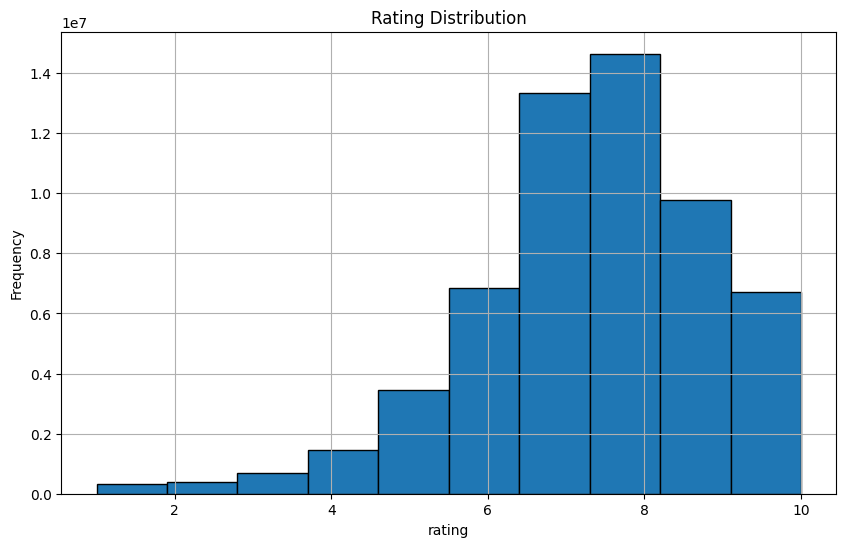

In [3]:
import matplotlib.pyplot as plt


x = dataset.ratings
plt.figure(figsize=(10,6))
plt.hist(x, bins=10, edgecolor='black') 
plt.title("Rating Distribution") 
plt.xlabel("rating") 
plt.ylabel("Frequency") 
plt.grid(True) 

# Separate the dataset

We split the dataset into training, test and validation

In [3]:
from torch.utils.data import random_split, DataLoader

train_dataset, test_dataset, validation_dataset = random_split(dataset, [0.7, 0.2, 0.1])

train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, shuffle=True)

print(len(train_dataloader))
print(len(test_dataloader))
print(len(validation_dataloader))

140081
40023
20011


# The Model

The model attempts to learn the features of the animes and of the users by embedding them using simple embedding tables.
This also means that the model size highly depends on the number of users and on the number of animes in the dataset.

A different method could also be attempted where the embedding is done without using embedding tables.

In [4]:
class MatrixFactorizationModel(t.nn.Module):
    def __init__(self, emb_size, device) -> None:
        super().__init__()
        self.device = device
        self.user_embedder = t.nn.Embedding(len(dataset.users), emb_size).to(device)
        self.anime_embedder = t.nn.Embedding(len(dataset.animes), emb_size).to(device)

    def forward(self, users, animes):
        users, animes = users.to(self.device), animes.to(self.device)
        # Users is [U, emb_size]
        users = self.user_embedder(users)
        # Users is [A, emb_size]
        animes = self.anime_embedder(animes)
        pred = t.nn.functional.leaky_relu(users @ animes.T)
        return pred

    def size(self):
        def human_format(num):
            magnitude = 0
            while abs(num) >= 1000:
                magnitude += 1
                num /= 1000.0
            # add more suffixes if you need them
            return "%.2f%s" % (num, ["", "K", "M", "G", "T", "P"][magnitude])

        return human_format(sum(p.numel() for p in self.parameters()))


model = MatrixFactorizationModel(emb_size=1024, device=device)
print(model.size())

334.78M


# Define a generic step

We perform this step regardless of the model, optimizer, or the phase we are in (training / test)

In [5]:
def run_step(model, loss_fn, users, anime, target):
    target = target.to(device=device).type(t.float32)
    target = target.squeeze()
    users = users.squeeze()
    anime = anime.squeeze()
    
    x = model(users, anime)
    #Only getting real ratings (range [1-10])
    mask = target != 0
    target = target[mask]
    x = x[mask]
    loss = loss_fn(x, target)
    return loss, x

# First Steps

Here we check if everything is set up correctly

In [6]:
loss_fn = t.nn.MSELoss()
learning_rate = 0.0001
optimizer = t.optim.Adam(model.parameters(), learning_rate)
users, animes, target = next(iter(train_dataloader))
loss, predictions = run_step(model, loss_fn, users, animes, target)
loss

tensor(360.7642, device='cuda:0', grad_fn=<MseLossBackward0>)

# Loading an existing model

It could be useful to start from where we left off.

In [7]:
import os


def get_unique_experiment_name():
    return model.__class__.__name__ + "_" + model.size()


models_dir = "/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/"
checkpoints = os.listdir(models_dir)
unique_name = get_unique_experiment_name()
checkpoints = [
    f for f in checkpoints if f[: min(len(unique_name), len(f))] == unique_name
]
if len(checkpoints) == 0:
    print("Starting from fresh: no models to load")
    epoch = 0
else:
    checkpoints.sort(key=lambda x: int(x[x.index("-") + 1 : -3]), reverse=True)

    epoch = int(checkpoints[0][checkpoints[0].index("-") + 1 : -3])
    print(f"Loading from {models_dir + checkpoints[0]}")
    model.load_state_dict(t.load(models_dir + checkpoints[0], weights_only=True))
    print(f"Loaded epoch {epoch}")

Starting from fresh: no models to load


# Training Loop

We set up a simple training loot that uses the validation and training sets to train the model

In [8]:
from tqdm import tqdm
from IPython.display import clear_output
import copy

train_losses = []
validation_losses = []

EVAL_EVERY = 10 # Only running evaluation step every 10 training steps

epochs = epoch + 4 # Set this to the number of training epochs you want to perform

with t.no_grad(): # To initialize the eval loss before training
    model.eval()
    us, an, ta = next(iter(validation_dataloader))
    loss, _ = run_step(model, loss_fn, us, an, ta)
    loss = loss.item()
    best_eval_loss = loss
    best_epoch = -1
    model.train()

while epoch < epochs:
    current_train_loss = t.empty(0, device="cpu")
    current_eval_loss = t.empty(0, device="cpu")

    i = 0
    for users, animes, target in tqdm(train_dataloader):
        #Training Step
        optimizer.zero_grad()
        loss, _ = run_step(model, loss_fn, users, animes, target)
        loss.backward()
        optimizer.step()
        current_train_loss = t.cat((current_train_loss, loss.to("cpu").unsqueeze(0)))

        if i == 0:
            #Validation Step
            with t.no_grad():
                model.eval()
                us, an, ta = next(iter(validation_dataloader))
                loss, _ = run_step(model, loss_fn, us, an, ta)
                current_eval_loss = t.cat((current_eval_loss, loss.to("cpu").unsqueeze(0)))
                loss = loss.item()
                if loss < best_eval_loss: # Getting the best model
                    best_eval_loss = loss
                    best_model = copy.deepcopy(model)
                    best_epoch = epoch
                model.train()
        i = (i + 1) % EVAL_EVERY

    train_losses = train_losses + current_train_loss.tolist()
    validation_losses = validation_losses + current_eval_loss.tolist()
    
    clear_output()
    print(f"Finished epoch {epoch}")
    print(
        f"Training loss average = {sum(current_train_loss) / len(current_train_loss)}"
    )
    eval_loss = sum(current_eval_loss) / len(current_eval_loss)
    print(f"Evaluation loss average = {eval_loss}")
    print(f"Current Best Epoch: {best_epoch}: Validation Loss: {best_eval_loss}")
    epoch += 1

print(f"Going back to epoch {best_epoch}: validation loss: {best_eval_loss}")
model = best_model
epoch = best_epoch

Finished epoch 3
Training loss average = 109.11869049072266
Evaluation loss average = 170.7519073486328
Current Best Epoch: 3: Validation Loss: 87.87049865722656
Going back to epoch 3: validation loss: 87.87049865722656


# Plotting the epochs

Using matplotlib to plot the result of the experiment

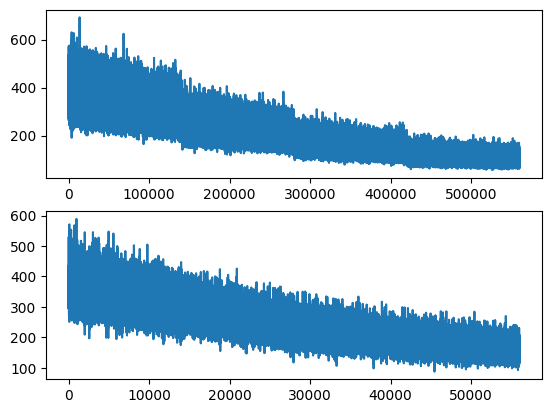

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)

x = list(range(1, len(train_losses) + 1))
axs[0].plot(x, train_losses)


x = list(range(1, len(validation_losses) + 1))
axs[1].plot(x, validation_losses)
plt.show()

# Saving the model

As long as we are carrying out the same experiment we should be able to save and load the model.
This saves a lot of time and allows us to restart from where we left off the previous time.

In [10]:
t.save(
    model.state_dict(),
    f"/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/{get_unique_experiment_name()}_epoch-{epoch}.pt",
)

# Testing

Iterating over the test set we can see how the model predicts user preferences on unseen user data.

In [11]:
from tqdm import tqdm

test_losses = []
y_true = []
y_pred = []

with t.no_grad():
    model.eval()
    for users, animes, target in tqdm(test_dataloader):
        loss, prediction_table = run_step(model, loss_fn, users, animes, target)
        loss = loss.item()
        test_losses.append(loss)

        #Only getting predictions we know to be true
        mask = target != 0
        target = target[mask].tolist()
        # prediction table has already been masked
        prediction_table = prediction_table.tolist()

        y_true += target
        y_pred += [round(pred) for pred in prediction_table]

100%|██████████| 40023/40023 [01:38<00:00, 406.08it/s]


In [12]:
from sklearn.metrics import r2_score, mean_absolute_error
print(f"Average test loss: {sum(test_losses) / len(test_losses)}")
print(f"R2 Score: {r2_score(y_true,y_pred)}")
print(f"On average the model gets it wrong by {mean_absolute_error(y_true, y_pred)} votes")

Average test loss: 179.05445254522473
R2 Score: -60.75862238324449
On average the model gets it wrong by 9.795569717551297 votes


In [28]:
print(f'y_true: {y_true[:10]}')
print(f'y_pred: {y_pred[:10]}')

y_true: [8, 5, 5, 9, 9, 7, 7, 8, 10, 8]
y_pred: [20, 0, 3, 0, 0, 0, 7, 11, 8, 9]
